In [1]:
## Attaches burn probabilities to the ZTRAX data
## Uses lat and long provided 
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from functools import reduce

In [2]:
pd.options.display.max_columns = None


In [3]:
## Get US Map for context and select Western United States
##Convert Coordinate Reference System to US Natinoal Atlas Equal Area
USMAP = gpd.read_file('/data/yoder/DensityProject/cb_2018_us_state_500k.shp')
USMAP = USMAP.to_crs("EPSG:2163")
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']

## Get map(s) of individual states if desired
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

In [4]:
scratchpath = '/data/yoder/AllZillow/HedonicData/'
os.chdir(scratchpath)
## List all tables included in Zillow Variable names excel file
ZTransLayout = pd.read_excel('Layout.xlsx','ZTrans')
ZTransLayout['TableName'].unique()
ZAsmtLayout = pd.read_excel('Layout.xlsx','ZAsmt')

## Create dataframes from each table name in the Zillow table dictionary
    ## Strip 'ut' from column names
T = {}
for name,group in ZTransLayout.groupby('TableName'):
    T[str(name)[2:]] = group
A = {}
for name, group in ZAsmtLayout.groupby('TableName'):
    A[str(name)[2:]] = group
    
    
## Dictionary of Western 11 states using Zillows numbering: 
states = {'CO':'08'}
# states = {'AZ':'04',
#           'CA':'06',
#           'CO':'08',
#           'ID':'16',
#           'MT':'30',
#           'NV':'32',
#           'NM':'35',
#           'OR':'41',
#           'UT':'49',
#           'WA':'53',
#           'WY':'56'}

In [5]:
#Change this value to the state and table you care about
# State to use
# state = states[West]
state_map = USMAP[USMAP['STUSPS']=='CO']
#Transaction tables to use
Ttables = ['Main', 'PropertyInfo']
# Assessment tables to use
Atables = ['Main','Garage', 'Building', 'Value']


## Fields to use from transaction tables
Tfields = {'Main': ['TransId','State','County','DocumentDate',
                    'RecordingDate','FIPS','DataClassStndCode',
                    'DocumentTypeStndCode',
                    'LoanTypeStndCode','PropertyUseStndCode',
                    'SalesPriceAmount', 'LoanAmount'],
            'PropertyInfo':['TransId','ImportParcelID','AssessorParcelNumber',
                            'PropertyFullStreetAddress','PropertyCity',
                            'PropertyState','PropertyAddressLatitude',
                            'PropertyAddressLongitude']}
## Fields not currently used
## 'IntraFamilyTransferFlag', 'SignatureDate',
# Fields to use from Assessment tables
Afields = {'Main': ['RowID','ImportParcelID','LotSizeSquareFeet'],
          'Garage':['RowID','GarageStndCode','GarageAreaSqFt'],
          'Building':['RowID','ArchitecturalStyleStndCode','BuildingClassStndCode','BuildingQualityStndCode',
                       'BuildingConditionStndCode','EffectiveYearBuilt','YearBuilt','YearRemodeled',
                       'NoOfStories','TotalRooms','TotalBedrooms','TotalKitchens',
                       'FullBath','ThreeQuarterBath','HalfBath','QuarterBath','TotalActualBathCount',
                       'TotalBathPlumbingFixtures','RoofCoverStndCode', 'RoofStructureTypeStndCode',
                       'HeatingTypeorSystemStndCode','AirConditioningTypeorSystemStndCode',
                       'FoundationTypeStndCode','ElevatorStndCode','FireplaceFlag',
                       'FireplaceNumber','WaterStndCode','SewerStndCode'],
          'Value': ['RowID','LandAssessedValue','ImprovementAssessedValue','TotalAssessedValue',
                    'AssessmentYear','LandMarketValue','ImprovementMarketValue','TotalMarketValue',
                    'MarketValueYear','LandAppraisalValue','ImprovementAppraisalValue','TotalAppraisalValue',
                    'AppraisalValueYear']} 
## Throws error if these are included 'FireplaceTypeStndCode','StoryTypeCode'
## Not currenlty used ,'TimeshareStndCode'

In [6]:
%%time
sts_trans = {}
sts_vals = {}
SetofStates = {}
for state in states.values():
    keys = Ttables
    dfs = {}
    for i in keys:
        print(f'Started loading {state} table {i}')
        dfs[i] = pd.read_csv(f'{state}/ZTrans\{i}.txt',sep = '|', header=None,names=T[i]['FieldName'].tolist(), encoding='latin1',usecols=Tfields[i])
        print(f'Finished loading {state}, table {i}')
    sts_trans[state] = reduce(lambda left,right: pd.merge(left,right,on='TransId',how='left'),dfs.values())   
    dfA = {}
    keys = Atables
    for j in keys:
        print(f'Started Loading Amt {state} table {i}')
        dfA[j] = pd.read_csv(f'{state}/ZAsmt\{j}.txt',sep='|', header=None,names=A[j]['FieldName'].tolist(),encoding='latin1',usecols=Afields[j])
        print(f'Finished Loading Amt {state} table {j}')
    sts_vals[state] =  reduce(lambda left, right:pd.merge(left,right,on='RowID',how='left'),dfA.values())
    SetofStates[state] = pd.merge(sts_trans[state],sts_vals[state],on='ImportParcelID',how='left')

Started loading 08 table Main


<decorator-gen-54>:2: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.


Finished loading 08, table Main
Started loading 08 table PropertyInfo


<decorator-gen-54>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


Finished loading 08, table PropertyInfo
Started Loading Amt 08 table PropertyInfo
Finished Loading Amt 08 table Main
Started Loading Amt 08 table PropertyInfo
Finished Loading Amt 08 table Garage
Started Loading Amt 08 table PropertyInfo


<decorator-gen-54>:2: DtypeWarning: Columns (9,10,12,29,30,31,32,33,34,35,38,39) have mixed types.Specify dtype option on import or set low_memory=False.


Finished Loading Amt 08 table Building
Started Loading Amt 08 table PropertyInfo
Finished Loading Amt 08 table Value
CPU times: user 2min 43s, sys: 26.2 s, total: 3min 9s
Wall time: 3min 27s


In [7]:
Atables

['Main', 'Garage', 'Building', 'Value']

In [8]:
df = SetofStates['08']

In [9]:
df

,TransId,FIPS,State,County,DataClassStndCode,RecordingDate,DocumentTypeStndCode,DocumentDate,SalesPriceAmount,PropertyUseStndCode,LoanAmount,LoanTypeStndCode,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,RowID,LotSizeSquareFeet,GarageStndCode,GarageAreaSqFt,BuildingClassStndCode,BuildingQualityStndCode,BuildingConditionStndCode,ArchitecturalStyleStndCode,YearBuilt,EffectiveYearBuilt,YearRemodeled,NoOfStories,TotalRooms,TotalBedrooms,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,TotalBathPlumbingFixtures,RoofCoverStndCode,RoofStructureTypeStndCode,HeatingTypeorSystemStndCode,AirConditioningTypeorSystemStndCode,FoundationTypeStndCode,ElevatorStndCode,FireplaceFlag,FireplaceNumber,WaterStndCode,SewerStndCode,LandAssessedValue,ImprovementAssessedValue,TotalAssessedValue,AssessmentYear,LandMarketValue,ImprovementMarketValue,TotalMarketValue,MarketValueYear,LandAppraisalValue,ImprovementAppraisalValue,TotalAppraisalValue,AppraisalValueYear
0,97922611,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,75000.0,NaN,75900.0,NaN,1719-14-4-02-039,1860 E 98TH PL,THORNTON,CO,39.876425,-104.964230,21608543.0,42751A16-820C-E811-80C3-3863BB430E3F,7841.0,AT,NaN,NaN,C,AV,RA,1975.0,NaN,NaN,1.0,5.0,3.0,NaN,1.0,NaN,0.0,NaN,NaN,896.0,CS,GBL,FA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5760.0,10060.0,15820.0,2017.0,80000.0,139740.0,219740.0,2017.0,NaN,NaN,NaN,NaN
1,97922611,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,75000.0,NaN,75900.0,NaN,1719-14-4-02-039,1860 E 98TH PL,THORNTON,CO,39.876425,-104.964230,21608543.0,42751A16-820C-E811-80C3-3863BB430E3F,7841.0,GR,816.0,NaN,C,AV,RA,1975.0,NaN,NaN,1.0,5.0,3.0,NaN,1.0,NaN,0.0,NaN,NaN,896.0,CS,GBL,FA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5760.0,10060.0,15820.0,2017.0,80000.0,139740.0,219740.0,2017.0,NaN,NaN,NaN,NaN
2,97922612,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,194100.0,UL,120000.0,NaN,1719-05-1-10-031,11673 DECATUR DR,WESTMINSTER,CO,39.908376,-105.019622,21593845.0,19ED3B16-820C-E811-80C3-3863BB430E3F,7841.0,AT,NaN,NaN,B,GD,NaN,1993.0,2013.0,2013.0,2.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,2.5,15.0,WS,GBL,FA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9360.0,19730.0,29090.0,2017.0,130000.0,274070.0,404070.0,2017.0,NaN,NaN,NaN,NaN
3,97922612,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,194100.0,UL,120000.0,NaN,1719-05-1-10-031,11673 DECATUR DR,WESTMINSTER,CO,39.908376,-105.019622,21593845.0,19ED3B16-820C-E811-80C3-3863BB430E3F,7841.0,GR,1.0,NaN,B,GD,NaN,1993.0,2013.0,2013.0,2.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,2.5,15.0,WS,GBL,FA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9360.0,19730.0,29090.0,2017.0,130000.0,274070.0,404070.0,2017.0,NaN,NaN,NaN,NaN
4,97922613,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,114900.0,NaN,103410.0,NaN,1719-05-3-09-042,3265 W 115TH PL,WESTMINSTER,CO,39.905624,-105.027946,21594200.0,DA2E5D16-820C-E811-80C3-3863BB430E3F,5663.0,AT,NaN,NaN,B,AV,NaN,1990.0,NaN,NaN,NaN,5.0,3.0,NaN,2.0,NaN,0.0,NaN,NaN,9.0,CS,GBL,FA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9360.0,12700.0,22060.0,2017.0,130000.0,176455.0,306455.0,2017.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19877934,449200102,8125,CO,YUMA,D,2018-10-18,INTR,2000-06-22,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19877935,449200103,8125,CO,YUMA,D,2018-10-18,INTR,2000-01-21,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19877936,449200104,8125,CO,YUMA,D,2018-10-18,INTR,2000-06-27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [10]:
%%time
df = pd.concat(SetofStates.values(), ignore_index=True)

CPU times: user 16.3 s, sys: 10.1 s, total: 26.4 s
Wall time: 26.4 s


In [11]:
df

,TransId,FIPS,State,County,DataClassStndCode,RecordingDate,DocumentTypeStndCode,DocumentDate,SalesPriceAmount,PropertyUseStndCode,LoanAmount,LoanTypeStndCode,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,RowID,LotSizeSquareFeet,GarageStndCode,GarageAreaSqFt,BuildingClassStndCode,BuildingQualityStndCode,BuildingConditionStndCode,ArchitecturalStyleStndCode,YearBuilt,EffectiveYearBuilt,YearRemodeled,NoOfStories,TotalRooms,TotalBedrooms,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,TotalBathPlumbingFixtures,RoofCoverStndCode,RoofStructureTypeStndCode,HeatingTypeorSystemStndCode,AirConditioningTypeorSystemStndCode,FoundationTypeStndCode,ElevatorStndCode,FireplaceFlag,FireplaceNumber,WaterStndCode,SewerStndCode,LandAssessedValue,ImprovementAssessedValue,TotalAssessedValue,AssessmentYear,LandMarketValue,ImprovementMarketValue,TotalMarketValue,MarketValueYear,LandAppraisalValue,ImprovementAppraisalValue,TotalAppraisalValue,AppraisalValueYear
0,97922611,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,75000.0,NaN,75900.0,NaN,1719-14-4-02-039,1860 E 98TH PL,THORNTON,CO,39.876425,-104.964230,21608543.0,42751A16-820C-E811-80C3-3863BB430E3F,7841.0,AT,NaN,NaN,C,AV,RA,1975.0,NaN,NaN,1.0,5.0,3.0,NaN,1.0,NaN,0.0,NaN,NaN,896.0,CS,GBL,FA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5760.0,10060.0,15820.0,2017.0,80000.0,139740.0,219740.0,2017.0,NaN,NaN,NaN,NaN
1,97922611,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,75000.0,NaN,75900.0,NaN,1719-14-4-02-039,1860 E 98TH PL,THORNTON,CO,39.876425,-104.964230,21608543.0,42751A16-820C-E811-80C3-3863BB430E3F,7841.0,GR,816.0,NaN,C,AV,RA,1975.0,NaN,NaN,1.0,5.0,3.0,NaN,1.0,NaN,0.0,NaN,NaN,896.0,CS,GBL,FA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5760.0,10060.0,15820.0,2017.0,80000.0,139740.0,219740.0,2017.0,NaN,NaN,NaN,NaN
2,97922612,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,194100.0,UL,120000.0,NaN,1719-05-1-10-031,11673 DECATUR DR,WESTMINSTER,CO,39.908376,-105.019622,21593845.0,19ED3B16-820C-E811-80C3-3863BB430E3F,7841.0,AT,NaN,NaN,B,GD,NaN,1993.0,2013.0,2013.0,2.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,2.5,15.0,WS,GBL,FA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9360.0,19730.0,29090.0,2017.0,130000.0,274070.0,404070.0,2017.0,NaN,NaN,NaN,NaN
3,97922612,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,194100.0,UL,120000.0,NaN,1719-05-1-10-031,11673 DECATUR DR,WESTMINSTER,CO,39.908376,-105.019622,21593845.0,19ED3B16-820C-E811-80C3-3863BB430E3F,7841.0,GR,1.0,NaN,B,GD,NaN,1993.0,2013.0,2013.0,2.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,2.5,15.0,WS,GBL,FA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9360.0,19730.0,29090.0,2017.0,130000.0,274070.0,404070.0,2017.0,NaN,NaN,NaN,NaN
4,97922613,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,114900.0,NaN,103410.0,NaN,1719-05-3-09-042,3265 W 115TH PL,WESTMINSTER,CO,39.905624,-105.027946,21594200.0,DA2E5D16-820C-E811-80C3-3863BB430E3F,5663.0,AT,NaN,NaN,B,AV,NaN,1990.0,NaN,NaN,NaN,5.0,3.0,NaN,2.0,NaN,0.0,NaN,NaN,9.0,CS,GBL,FA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9360.0,12700.0,22060.0,2017.0,130000.0,176455.0,306455.0,2017.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19877934,449200102,8125,CO,YUMA,D,2018-10-18,INTR,2000-06-22,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19877935,449200103,8125,CO,YUMA,D,2018-10-18,INTR,2000-01-21,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19877936,449200104,8125,CO,YUMA,D,2018-10-18,INTR,2000-06-27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
## Select only valid transactions
UnwantedLoanCodes =  ['AC','CT','CM','CS','CC','CL','DP','FO','FE','HE','LC','EB','EX','MD','NA','NP','FA','RE','RM','SM','SE','TR']
WantedLoanCodes =  ['AS','BL','CE','FM','PM','RD','SL']
DocumentTypeStndCodeDrop= ['CRDE','JTDE','QCDE','RRDE','VLDE']
DocumentTypeStndCodeKeep= ['CPDE','IDDE','PRDE','WRDE']

In [13]:
df.columns

Index(['TransId', 'FIPS', 'State', 'County', 'DataClassStndCode',
       'RecordingDate', 'DocumentTypeStndCode', 'DocumentDate',
       'SalesPriceAmount', 'PropertyUseStndCode', 'LoanAmount',
       'LoanTypeStndCode', 'AssessorParcelNumber', 'PropertyFullStreetAddress',
       'PropertyCity', 'PropertyState', 'PropertyAddressLatitude',
       'PropertyAddressLongitude', 'ImportParcelID', 'RowID',
       'LotSizeSquareFeet', 'GarageStndCode', 'GarageAreaSqFt',
       'BuildingClassStndCode', 'BuildingQualityStndCode',
       'BuildingConditionStndCode', 'ArchitecturalStyleStndCode', 'YearBuilt',
       'EffectiveYearBuilt', 'YearRemodeled', 'NoOfStories', 'TotalRooms',
       'TotalBedrooms', 'TotalKitchens', 'FullBath', 'ThreeQuarterBath',
       'HalfBath', 'QuarterBath', 'TotalActualBathCount',
       'TotalBathPlumbingFixtures', 'RoofCoverStndCode',
       'RoofStructureTypeStndCode', 'HeatingTypeorSystemStndCode',
       'AirConditioningTypeorSystemStndCode', 'FoundationTypeStnd

In [14]:
## Select only valid transactions
st = df.loc[(df['SalesPriceAmount'] > 0) &
            (~df['LoanTypeStndCode'].isin(UnwantedLoanCodes)) &
#             (pd.isnull(df['IntraFamilyTransferFlag'])) &
            (df['PropertyUseStndCode']=='SR') &
            (df['DocumentTypeStndCode'].isin(DocumentTypeStndCodeKeep)) & 
            (df['TotalBedrooms'] >=1)].copy()

In [15]:
st = gpd.GeoDataFrame(st, geometry = gpd.points_from_xy(st.PropertyAddressLongitude, st.PropertyAddressLatitude))
st_proj = st.copy()
st_proj.crs="epsg:4326"
st_proj=st_proj.to_crs("EPSG:2163")
st_proj.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [16]:
import rasterio
from rasterstats import zonal_stats, point_query
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [17]:
## Reproject raster and load it

dst_crs ="EPSG:2163"

with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
                   reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                
src = rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

/home/joshua.olsen/.conda/envs/testenv/lib/python3.8/site-packages/matplotlib/image.py:490: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


<AxesSubplot:>

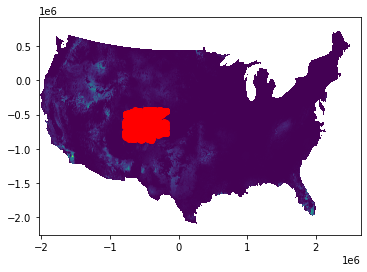

In [18]:
## Plot points
fig, ax = plt.subplots()
show(src,ax = ax)
st_proj.plot(ax=ax, color ='red')

In [19]:
pts = st_proj.copy()

In [20]:
st_proj.shape

(1375077, 63)

In [21]:
## Select only valid geometry (note .isna() does not appear to catch point (nan,nan))
st_pts = st_proj[st_proj['geometry'].is_valid]
st_pts = gpd.clip(st_pts, state_map)

In [22]:
st_pts.shape

(1374190, 63)

<AxesSubplot:>

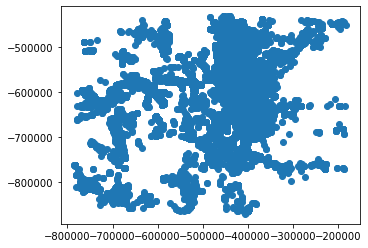

In [23]:
st_pts.plot()

In [24]:
pts = st_pts.copy()

In [ ]:
%%time
## Add burn probability that the location is within (landfire uses 270 meter pixels)
pts['BP'] = point_query(pts, '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

In [ ]:
%%time
## Add burn probability out to 1600 meters
pts['point_geometry'] = pts['geometry'].copy()
pts['geometry'] = pts.buffer(1600)
buff = pd.DataFrame(zonal_stats(pts, 
                             '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif',
                            stats=['max','mean']))
buff.columns = [f'BP1600_'+str(col) for col in buff.columns]

buff.reset_index(drop=True,inplace=True)
pts.reset_index(drop=True,inplace=True)
pts = pd.concat([pts,buff],axis=1)
pts['geometry'] = pts['point_geometry'].copy()

In [ ]:
BurnCols = ['BP','BP1600_max','BP1600_mean']

In [ ]:
df = pts.copy()

In [ ]:
%%time
ST_points = df.copy()
## Add fire perimeter data
import geopandas as gpd
Fireperims = gpd.read_file('/data/yoder/DensityProject/mtbs_perimeter_data/mtbs_perims_DD.shp')
Fireperims = Fireperims.to_crs("EPSG:2163")

state_map = state_map[['STUSPS', 'geometry']]
Buffed_state = state_map.copy()
Buffed_state['geometry'] = Buffed_state.buffer(20000)
ST_fires = gpd.sjoin(Fireperims, Buffed_state, op='within')
ST_fires = ST_fires.drop(['index_right'], axis=1)
ST_fires['Buffed_geometry100km'] = ST_fires.buffer(20000)
ST_fires['MTBS_geometry'] = ST_fires['geometry'].copy()
ST_fires['geometry'] = ST_fires['Buffed_geometry100km'].copy()


In [ ]:
basemap = state_map.plot(edgecolor='black',color='white')
ST_fires.plot(ax=basemap, color='red')
ST_points.plot(ax= basemap, color='blue')

In [ ]:
%%time
ST_Samp_with_Fires = gpd.sjoin(ST_points, ST_fires, how='left')

In [ ]:
def get_distance(row):
    distance = row.geometry.distance(row.MTBS_geometry)
    return distance

In [ ]:
HomesAroundFires = ST_Samp_with_Fires[ST_Samp_with_Fires.MTBS_geometry.notnull()].copy()

In [ ]:
HomesNotAroundFires = ST_Samp_with_Fires[ST_Samp_with_Fires.MTBS_geometry.isnull()].copy()

In [ ]:
%%time
HomesAroundFires['Distance'] = HomesAroundFires.apply(lambda row: get_distance(row),axis=1)

In [ ]:
import pickle
pickle.dump(HomesAroundFires, open( "COHomesAroundFires.p", "wb" ) )

In [ ]:
df.shape

In [ ]:
HAF = HomesAroundFires

In [ ]:
HNAF = HomesNotAroundFires

In [ ]:
HAF

In [ ]:
df = HAF

In [ ]:
df['RecordingDate'] =pd.to_datetime(df['RecordingDate'])
df['Year'] = df.RecordingDate.dt.year

In [ ]:
# HAF.groupby('BuildingQualityStndCode')['TransId'].count()

In [ ]:
df.groupby('RoofCoverStndCode')['TransId'].count()

In [ ]:
## Convert to 2020 dollars
CPI = pd.read_csv(scratchpath+'/InfAdjust.csv')
df = pd.merge(df,CPI,on='Year',how='left')
df['SalesPrice'] = df['SalesPriceAmount']/df['Deflator_base2020']
df['LoanAmt'] = df['LoanAmount']/df['Deflator_base2020']

In [ ]:
## Select only valid transactions
UnwantedLoanCodes =  ['AC','CT','CM','CS','CC','CL','DP','FO','FE','HE','LC','EB','EX','MD','NA','NP','FA','RE','RM','SM','SE','TR']
WantedLoanCodes =  ['AS','BL','CE','FM','PM','RD','SL']
DocumentTypeStndCodeDrop= ['CRDE','JTDE','QCDE','RRDE','VLDE']
DocumentTypeStndCodeKeep= ['CPDE','IDDE','PRDE','WRDE']


st = df.loc[(df['SalesPriceAmount'] > 0) &
            (~df['LoanTypeStndCode'].isin(UnwantedLoanCodes)) &
#             (pd.isnull(df['IntraFamilyTransferFlag'])) &
            (df['PropertyUseStndCode']=='SR') &
            (df['DocumentTypeStndCode'].isin(DocumentTypeStndCodeKeep)) & 
            (df['TotalBedrooms'] >=1)].copy()

In [ ]:
st = st.drop(['TimeshareStndCode',
              'AssessorParcelNumber','PropertyAddressLatitude',
                 'PropertyAddressLongitude','ImportParcelID'],axis=1)

In [ ]:
st =st.drop(['State'], axis=1)

In [ ]:
rooftypes = pd.get_dummies(st['RoofCoverStndCode'],prefix='roof')

In [ ]:
df = pd.concat([st, rooftypes], axis=1)

In [ ]:
roofs = rooftypes.columns

In [ ]:
samp = df.copy()

In [ ]:
samp['Bathrooms'] = samp['FullBath'].replace(np.nan, 0) + samp['ThreeQuarterBath'].replace(np.nan, 0) + samp['HalfBath'].replace(np.nan, 0) +samp['QuarterBath'].replace(np.nan, 0)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind


In [ ]:
roofs

In [ ]:
roofs.values

In [ ]:
samp.groupby('RoofCoverStndCode')['TransId'].count()

In [ ]:
BP_geq0 = samp.copy()

In [ ]:
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='AP', 'AsphaltRoof'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='AP', 'AsphaltRoof'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='AS', 'Asbestos'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='AS', 'Asbestos'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='BR', 'Bermuda'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='BR', 'Bermuda'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='BU', 'BuiltUpRoof'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='BU', 'BuiltUpRoof'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='CN', 'ConcreteRoof'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='CN', 'ConcreteRoof'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='CS', 'CompositShingle'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='CS', 'CompositShingle'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='ME', 'MetalRoof'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='ME', 'MetalRoof'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='TL', 'TileRoof'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='TL', 'TileRoof'] = 0
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='WS', 'Wood'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='WG', 'Wood'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] =='WD', 'Wood'] = 1
BP_geq0.loc[BP_geq0['RoofCoverStndCode'] !='WS', 'Wood'] = 0

In [ ]:
samp = BP_geq0.copy()

In [ ]:
samp = samp[samp['SalesPrice'] > 10000].copy()
samp = samp[samp['SalesPrice'] < 5000000].copy()

In [ ]:
samp = samp.drop_duplicates(subset=['TransId'])

In [ ]:
samp['BP'].describe()

In [ ]:
## .001 1 in 1,000
## .0001 1 in 10,000

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
samp[samp['BP']>0].describe()

In [ ]:
samp = samp[samp['BP']>.0001]

In [ ]:
extras    +  BP*AsphaltRoo + BP*CompositShingle + BP*MetalRoof + BP*Wood 

In [ ]:
samp['BP1600_max'].describe()

In [ ]:
samp

In [ ]:
samp['BP'] = samp['BP']*10000

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
samp.describe()

In [ ]:
samp['BP'].describe()

In [ ]:
samp[samp['BP']>40]['BP'].mean()

In [ ]:
riskdummies = pd.cut(samp.BP, bins=[0, 10, 20, 30, 40, 10000], labels = ['verylow', 
       'low', 'moderate', 'high', 'veryhigh',])

In [ ]:
samp

In [ ]:
riskdummies

In [ ]:
samp['risklevel'] = riskdummies

In [ ]:
samp[['BuildingQualityStndCode']].value_counts()

In [ ]:
samp

In [ ]:
samp['LotSizeSquareFeet'] = samp['LotSizeSquareFeet']/1000

In [ ]:
samp[['SalesPrice','Year','BuildingQualityStndCode','TotalBedrooms', 'LotSizeSquareFeet',
     'Bathrooms','YearBuilt', 'BP','Wood']].describe()

In [ ]:
Linear = smf.ols(formula = f'SalesPrice ~ C(Year) + BuildingQualityStndCode+ TotalBedrooms  + LotSizeSquareFeet + Bathrooms +  C(YearBuilt) + Wood*BP', data=samp).fit()

In [ ]:
Log = smf.ols(formula = f'np.log(SalesPrice) ~ C(Year) + BuildingQualityStndCode+ TotalBedrooms  + LotSizeSquareFeet + Bathrooms +  C(YearBuilt) + Wood*BP', data=samp).fit()

In [ ]:
LinearLevels = smf.ols(formula = f'SalesPrice ~ C(Year) + BuildingQualityStndCode+ TotalBedrooms  + LotSizeSquareFeet + Bathrooms +  C(YearBuilt) + Wood*C(risklevel)', data=samp).fit()

In [ ]:
LogLevels = smf.ols(formula = f'np.log(SalesPrice) ~ C(Year) + BuildingQualityStndCode+ TotalBedrooms  + LotSizeSquareFeet + Bathrooms + C(YearBuilt) + Wood*C(risklevel)', data=samp).fit()

In [ ]:
samp['BP'].mean()

In [ ]:
summary_col([Linear, LinearLevels, Log, LogLevels], stars=True,
            regressor_order = ['Intercept','Year','BuildingQualityStndCode','TotalBedrooms', 'LotSizeSquareFeet',
     'Bathrooms','YearBuilt', 'BP','Wood', 'Wood:BP', 'C(risklevel)[T.verylow]', 
       'C(risklevel)[T.low]','Wood:C(risklevel)[T.low]',
                              'C(risklevel)[T.moderate]','Wood:C(risklevel)[T.moderate]',
                               'C(risklevel)[T.high]','Wood:C(risklevel)[T.high]',
                               'C(risklevel)[T.veryhigh]','Wood:C(risklevel)[T.veryhigh]' ])

In [ ]:
Mod1.summary2()

In [260]:
samp.groupby('risklevel')['TransId'].count()

risklevel
verylow     70191
low         24734
moderate     7452
high         4718
veryhigh    22212
Name: TransId, dtype: int64

In [261]:
Mod1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Ordinary least squares
=================================================================================================
Model:                        OLS                       Adj. R-squared:              0.496       
Dependent Variable:           SalesPrice                AIC:                         3198968.4218
Date:                         2021-08-19 17:55          BIC:                         3199461.9604
No. Observations:             117857                    Log-Likelihood:              -1.5994e+06 
Df Model:                     50                        F-statistic:                 2325.       
Df Residuals:                 117806                    Prob (F-statistic):          0.00        
R-squared:                    0.497                     Scale:                       3.5917e+10  
-------------------------------------------------------------------------------------------------
                                 Coef.      Std.Err.      t     P>|t|      [0.025       0.975]   
-------------------------------------------------------------------------------------------------
Intercept                     2040170.7469 60063.9282   33.9667 0.0000  1922446.4013 2157895.0926
C(Year)[T.1994]                  5715.3149  6824.0430    0.8375 0.4023    -7659.7011   19090.3309
C(Year)[T.1995]                 13690.9622  6840.0489    2.0016 0.0453      284.5750   27097.3493
C(Year)[T.1996]                  8404.5537  6763.9638    1.2425 0.2140    -4852.7080   21661.8154
C(Year)[T.1997]                 20898.9871  6601.9096    3.1656 0.0015     7959.3492   33838.6251
C(Year)[T.1998]                 39055.7174  6548.0168    5.9645 0.0000    26221.7083   51889.7264
C(Year)[T.1999]                 59727.2807  6541.0085    9.1312 0.0000    46907.0079   72547.5534
C(Year)[T.2000]                 96150.5831  6562.4606   14.6516 0.0000    83288.2646  109012.9016
C(Year)[T.2001]                121780.5327  6532.6683   18.6418 0.0000   108976.6065  134584.4589
C(Year)[T.2002]                136420.1588  6567.6922   20.7714 0.0000   123547.5864  149292.7313
C(Year)[T.2003]                140510.4128  6567.5258   21.3947 0.0000   127638.1665  153382.6591
C(Year)[T.2004]                152139.8535  6619.4018   22.9839 0.0000   139165.9312  165113.7758
C(Year)[T.2005]                166995.8327  6632.6127   25.1780 0.0000   153996.0172  179995.6482
C(Year)[T.2006]                180450.8444  6724.7770   26.8337 0.0000   167270.3882  193631.3006
C(Year)[T.2007]                182749.8564  6820.4082   26.7946 0.0000   169381.9646  196117.7482
C(Year)[T.2008]                162147.9491  7237.5275   22.4038 0.0000   147962.5100  176333.3881
C(Year)[T.2009]                123417.8045  7581.9860   16.2778 0.0000   108557.2323  138278.3767
C(Year)[T.2010]                124965.9036  7600.7838   16.4412 0.0000   110068.4879  139863.3192
C(Year)[T.2011]                 96559.7661  7507.4791   12.8618 0.0000    81845.2263  111274.3059
C(Year)[T.2012]                103413.5746  7278.1313   14.2088 0.0000    89148.5529  117678.5963
C(Year)[T.2013]                113818.7047  6999.7297   16.2604 0.0000   100099.3456  127538.0638
C(Year)[T.2014]                115731.3009  6915.2489   16.7357 0.0000   102177.5228  129285.0790
C(Year)[T.2015]                150813.1075  6854.5013   22.0021 0.0000   137378.3939  164247.8212
C(Year)[T.2016]                166141.3016  6851.3717   24.2493 0.0000   152712.7220  179569.8813
C(Year)[T.2017]                189507.7151  6799.8003   27.8696 0.0000   176180.2145  202835.2158
C(Year)[T.2018]                201223.0801  6926.5032   29.0512 0.0000   187647.2437  214798.9165
BuildingQualityStndCode[T.A+]  391463.8275 18799.1284   20.8235 0.0000   354617.8344  428309.8207
BuildingQualityStndCode[T.A-] -293060.3952  8501.6106  -34.4712 0.0000  -309723.4170 -276397.3735
BuildingQualityStndCode[T.B]  -724003.5809  7236.6331 -100.0470 

In [144]:
# Mod1.get_robustcov_results().summary()

In [ ]:
Mod0 = smf.ols(formula = f'SalesPrice ~ C(Year) + BuildingQualityStndCode+ TotalBedrooms + Bathrooms +  YearBuilt + BP1600_max*AsphaltRoof  + BP1600_max*CompositShingle  + BP1600_max*MetalRoof + BP1600_max*Wood', data=samp).fit()

In [ ]:
Mod0.get_robustcov_results().summary()

In [ ]:
samp = data[['TransId','RecordingDate','SalesPriceAmount','FIPS','County','PropertyCity',
             'LotSizeSquareFeet','GarageStndCode','GarageAreaSqFt',
             'BuildingQualityStndCode','BuildingConditionStndCode','ArchitecturalStyleStndCode',
            'YearBuilt','TotalBedrooms','FullBath','ThreeQuarterBath','HalfBath','QuarterBath',
            'RoofCoverStndCode','RoofStructureTypeStndCode','HeatingTypeorSystemStndCode',
            'AirConditioningTypeorSystemStndCode','FireplaceNumber',
            'BP','BP1600_max','WoodRoof','SalesPrice','LoanAmt']].copy()